In [1]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Download the dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-02-21 02:08:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  21.0MB/s    in 3.8s    

2023-02-21 02:08:47 (17.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Training cat pictures path
train_cats_dir = os.path.join(train_dir, 'cats')

# Training dog pictures path
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Validation cat pictures path
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Validation dog pictures path
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
# helper function to load image and return it and input vector
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,  
                                weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [5]:
# freeze all layers
for layer in pre_trained_model.layers:
  layer.trainable = False     

In [8]:
from tensorflow.keras.optimizers import RMSprop

# Flatten output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense (1, activation='sigmoid')(x)

from tensorflow.keras import Model
model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [9]:
# Add our data-augmentation parameters to ImageDatagenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# training
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 30,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/30
100/100 - 39s - loss: 1.0443 - acc: 0.8350 - val_loss: 0.8164 - val_acc: 0.7710 - 39s/epoch - 385ms/step
Epoch 2/30
100/100 - 25s - loss: 0.3963 - acc: 0.8855 - val_loss: 0.2974 - val_acc: 0.9080 - 25s/epoch - 250ms/step
Epoch 3/30
100/100 - 38s - loss: 0.2584 - acc: 0.9140 - val_loss: 0.2049 - val_acc: 0.9320 - 38s/epoch - 378ms/step
Epoch 4/30
100/100 - 32s - loss: 0.2571 - acc: 0.9150 - val_loss: 0.1696 - val_acc: 0.9390 - 32s/epoch - 323ms/step
Epoch 5/30
100/100 - 36s - loss: 0.2577 - acc: 0.9195 - val_loss: 0.2913 - val_acc: 0.9130 - 36s/epoch - 358ms/step
Epoch 6/30
100/100 - 45s - loss: 0.2513 - acc: 0.9190 - val_loss: 0.1785 - val_acc: 0.9330 - 45s/epoch - 449ms/step
Epoch 7/30
100/100 - 34s - loss: 0.2326 - acc: 0.9195 - val_loss: 0.2058 - val_acc: 0.9360 - 34s/epoch - 337ms/step
Epoch 8/30
100/100 - 32s - loss: 0.1970 - acc: 0.9285 - val_loss: 0.2100 - val_acc: 0.9320 - 32s/epoch - 322ms/step
Epoch 9/30
100/100 - 25s - loss: 0.2111 - acc: 0.9260 - val_loss: 0.2091

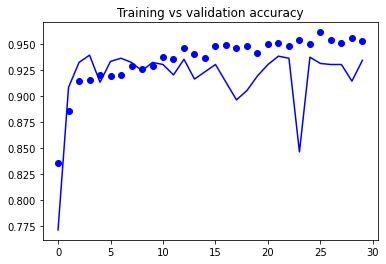

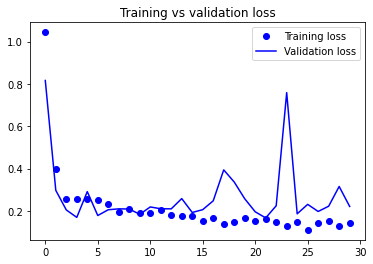

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training vs validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training vs validation loss')
plt.legend()

plt.show()